In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, pi
import cv2, os
import tensorflow as tf

from tensorflow.keras import layers, callbacks, utils, applications, optimizers
from tensorflow.keras.models import Sequential, Model, load_model

from tqdm.auto import tqdm
import seaborn as sns

os.environ["PATH"] += os.pathsep + 'C:/Users/xingzhe-mac/Graphviz/bin/'


In [2]:
train_file = 'data/facial-keypoints-detection/training.csv'
test_file = 'data/facial-keypoints-detection/test.csv'
idlookup_file = 'data/facial-keypoints-detection/IdLookupTable.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

In [8]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=50)
    plt.title(title)

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
        #print(type(image))
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

In [7]:
clean_train_data = train_data.dropna()
print("clean_train_data shape:", np.shape(clean_train_data))

unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape:", np.shape(unclean_train_data))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)


In [9]:
clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images:", np.shape(clean_train_images))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints:", np.shape(clean_train_keypoints))
test_images = load_images(test_data)
print("Shape of test_images:", np.shape(test_images))

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)


In [16]:
#clean_train_data.to_csv('clean_data_keypoints.csv',index=False)
#print(list(clean_train_data.columns.values))
#np.savetxt("keypoints_cleanData.csv", clean_train_keypoints, delimiter=",")

['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']


Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)


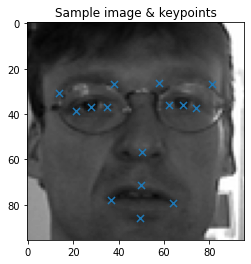

In [6]:
train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[15], clean_train_keypoints[15], axis, "Sample image & keypoints")

unclean_train_images = load_images(unclean_train_data)
print("Shape of unclean_train_images:", np.shape(unclean_train_images))
unclean_train_keypoints = load_keypoints(unclean_train_data)
print("Shape of unclean_train_keypoints:", np.shape(unclean_train_keypoints))
train_images = np.concatenate((train_images, unclean_train_images))
train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

In [7]:
class config:
    horizontal_flip = True
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True

    rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
    pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

    NUM_EPOCHS = 100
    BATCH_SIZE = 64

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)


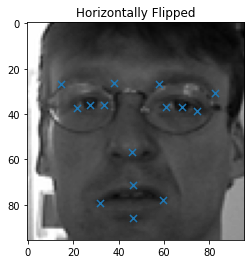

In [8]:
# Augmentation
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if config.horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images:", np.shape(flipped_train_images))
    print("Shape of flipped_train_keypoints:", np.shape(flipped_train_keypoints))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[15], flipped_train_keypoints[15], axis, "Horizontally Flipped") 


Augmenting for angles (in degrees): 
12  -12  Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)


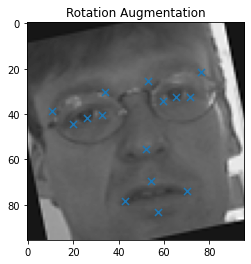

In [9]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in config.rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

print()

if config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("Shape of rotated_train_images:", np.shape(rotated_train_images))
    print("Shape of rotated_train_keypoints:", np.shape(rotated_train_keypoints))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[15], rotated_train_keypoints[15], axis, "Rotation Augmentation")

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


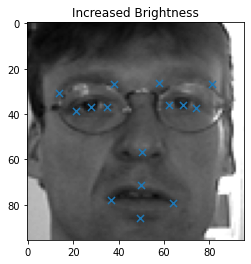

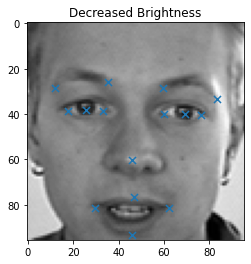

In [10]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if config.brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print("Shape of altered_brightness_train_images:", np.shape(altered_brightness_train_images))
    print("Shape of altered_brightness_train_keypoints:", np.shape(altered_brightness_train_keypoints))
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[15], altered_brightness_train_keypoints[15], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+19], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+19], axis, "Decreased Brightness") 

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


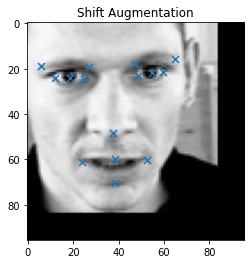

In [11]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in config.pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y)for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print("Shape of shifted_train_images:", np.shape(shifted_train_images))
    print("Shape of shifted_train_keypoints:", np.shape(shifted_train_keypoints))
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[15], shifted_train_keypoints[15], axis, "Shift Augmentation")

Shape of noisy_train_images: (2140, 96, 96, 1)


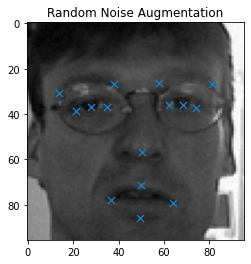

In [12]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if config.random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print("Shape of noisy_train_images:", np.shape(noisy_train_images))
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[15], clean_train_keypoints[15], axis, "Random Noise Augmentation")

Shape of final train_images: (28379, 96, 96, 1)
Shape of final train_keypoints: (28379, 30)

Clean Train Data: 


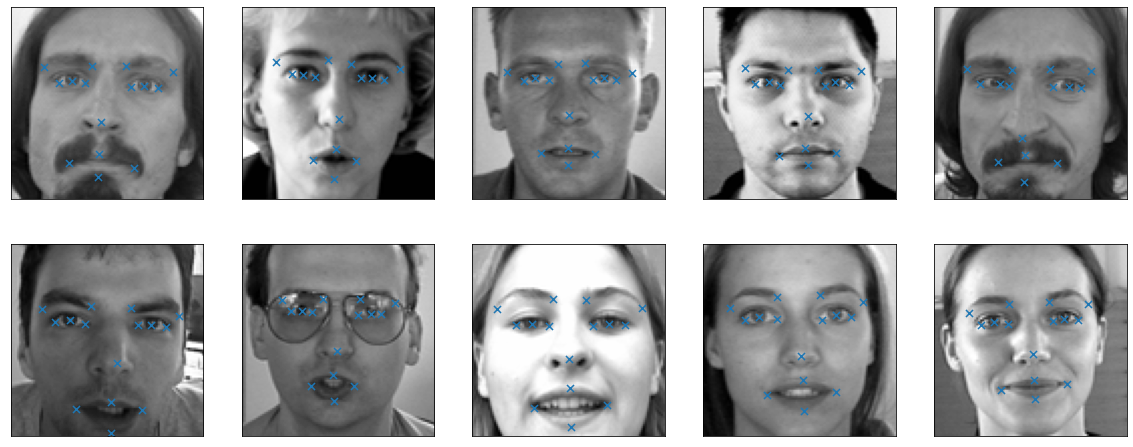

Unclean Train Data: 


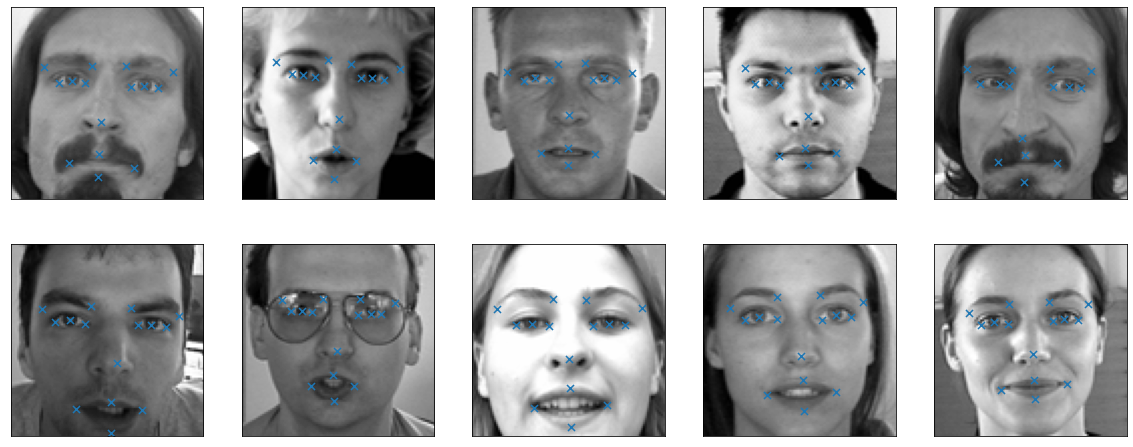

Horizontal Flip Augmentation: 


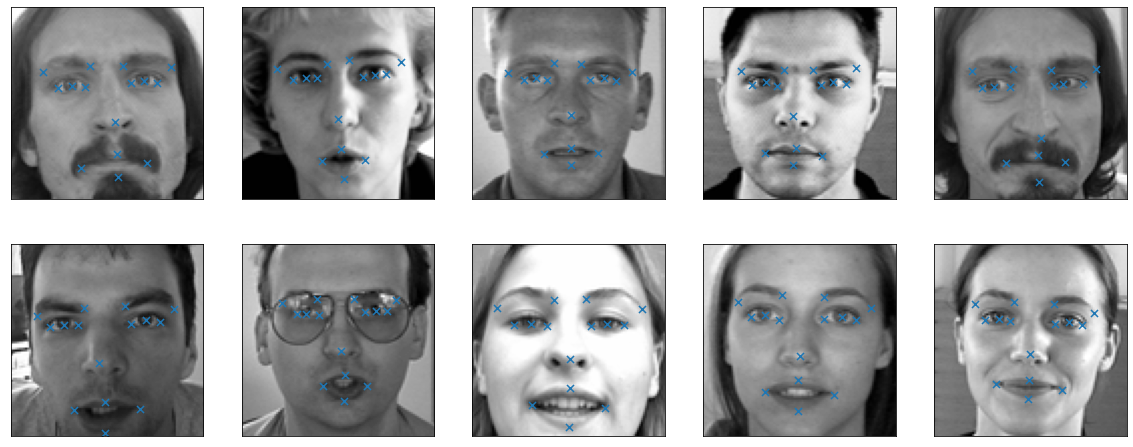

Rotation Augmentation: 


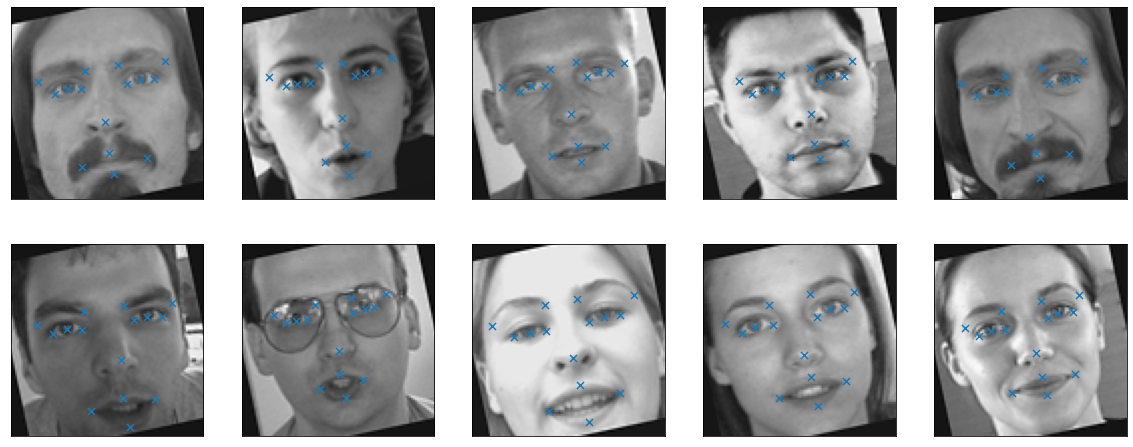

Brightness Augmentation: 


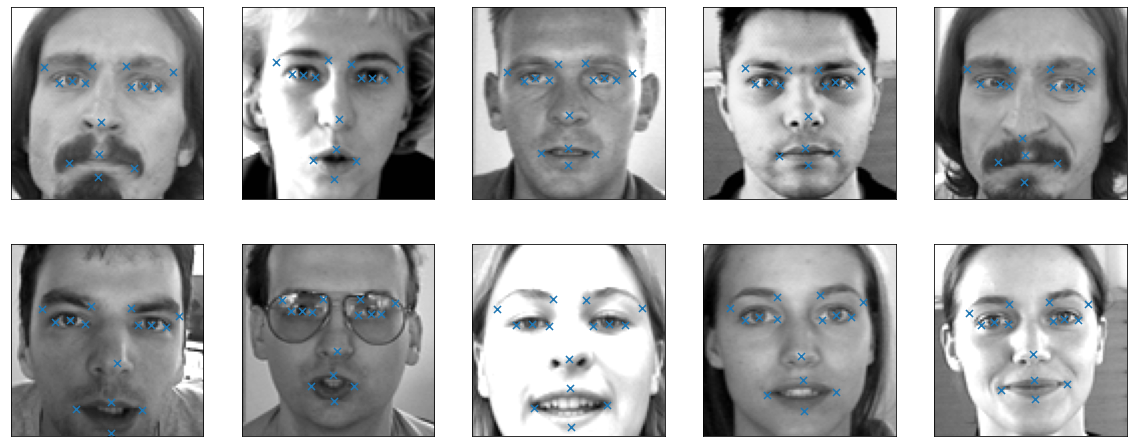

Shift Augmentation: 


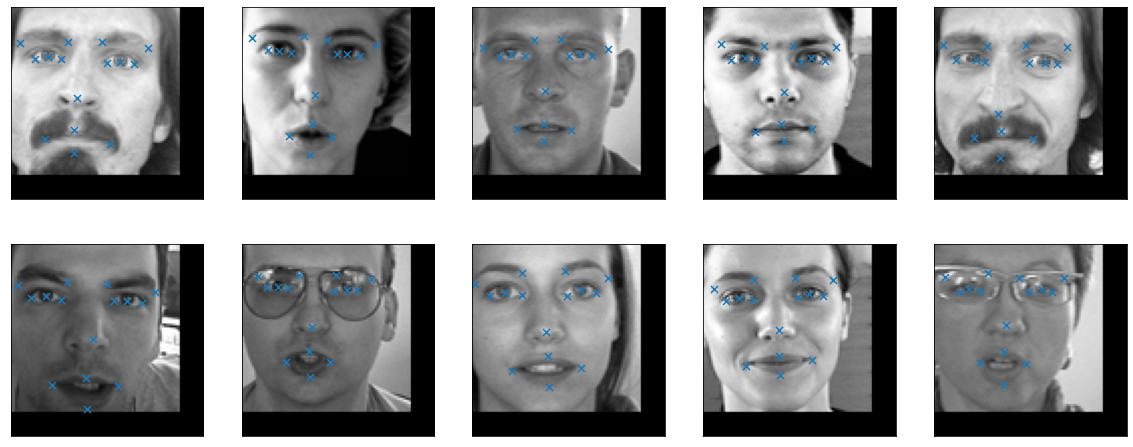

Random Noise Augmentation: 


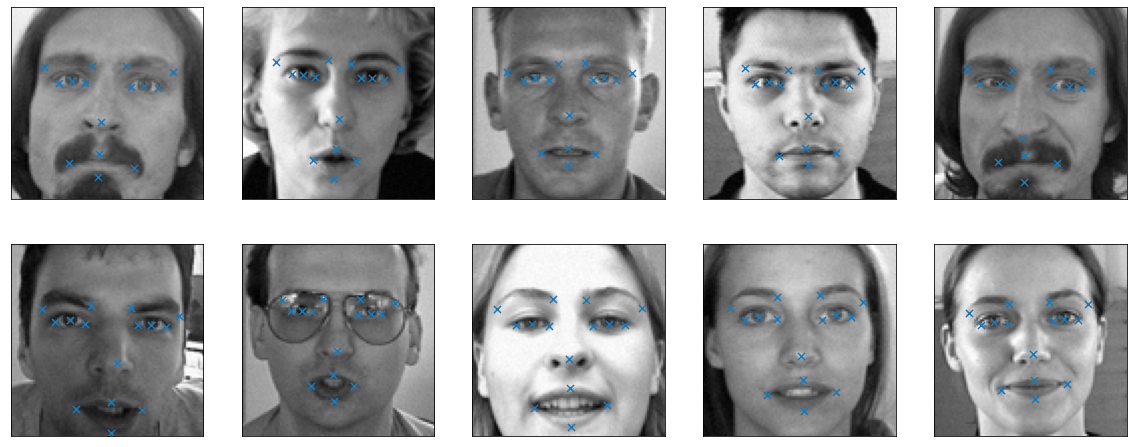

In [13]:
print("Shape of final train_images:", np.shape(train_images))
print("Shape of final train_keypoints:", np.shape(train_keypoints))

print("\nClean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

print("Unclean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
plt.show()

if config.horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if config.rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if config.brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if config.shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if config.random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

In [14]:
model = Sequential()

pretrained_model = tf.keras.applications.MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(layers.Conv2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model.add(layers.LeakyReLU(alpha = 0.1))
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(30))
model.build(input_shape=(None, 96, 96, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                30750     
Total params: 3,259,620
Trainable params: 3,237,732
Non-trainable params: 21,888
_________________________________________

In [15]:
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [16]:
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']
)

history = model.fit(
    train_images, train_keypoints, epochs=int(1.5*config.NUM_EPOCHS), batch_size=config.BATCH_SIZE, 
    validation_split=0.05, callbacks=[es, rlp]
)


" es = callbacks.EarlyStopping(\n    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True\n)\n\nrlp = callbacks.ReduceLROnPlateau(\n    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1\n)\n\nmodel.compile(\n    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']\n)\n\nhistory = model.fit(\n    train_images, train_keypoints, epochs=int(1.5*config.NUM_EPOCHS), batch_size=config.BATCH_SIZE, \n    validation_split=0.05, callbacks=[es, rlp]\n)\n "

In [17]:
#model.save("keypoint_model.h5")

In [2]:
model = load_model("keypoint_model.h5")

In [3]:
# test my own data
own_test_images = []
for img in os.listdir("G:/MacSharedFolder/Test_data"):
    im = cv2.imread(os.path.join("G:/MacSharedFolder/Test_data", img))
    im_res = cv2.resize(im, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    im_gray = cv2.cvtColor(im_res, cv2.COLOR_BGR2GRAY)
    im_gray = np.reshape(im_gray, (96,96,1))
    own_test_images.append(im_gray)
own_test_images = np.array(own_test_images)/255



In [5]:
%%time
test_preds = model.predict(own_test_images)

Wall time: 656 ms


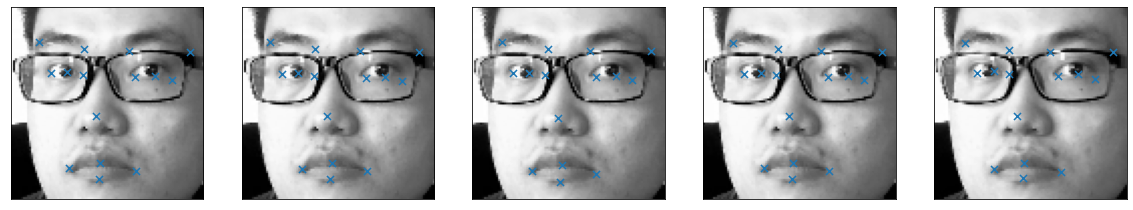

In [8]:
fig = plt.figure(figsize=(20,4))
for i in range(5):
    axis = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    plot_sample(own_test_images[i], test_preds[i], axis, "")

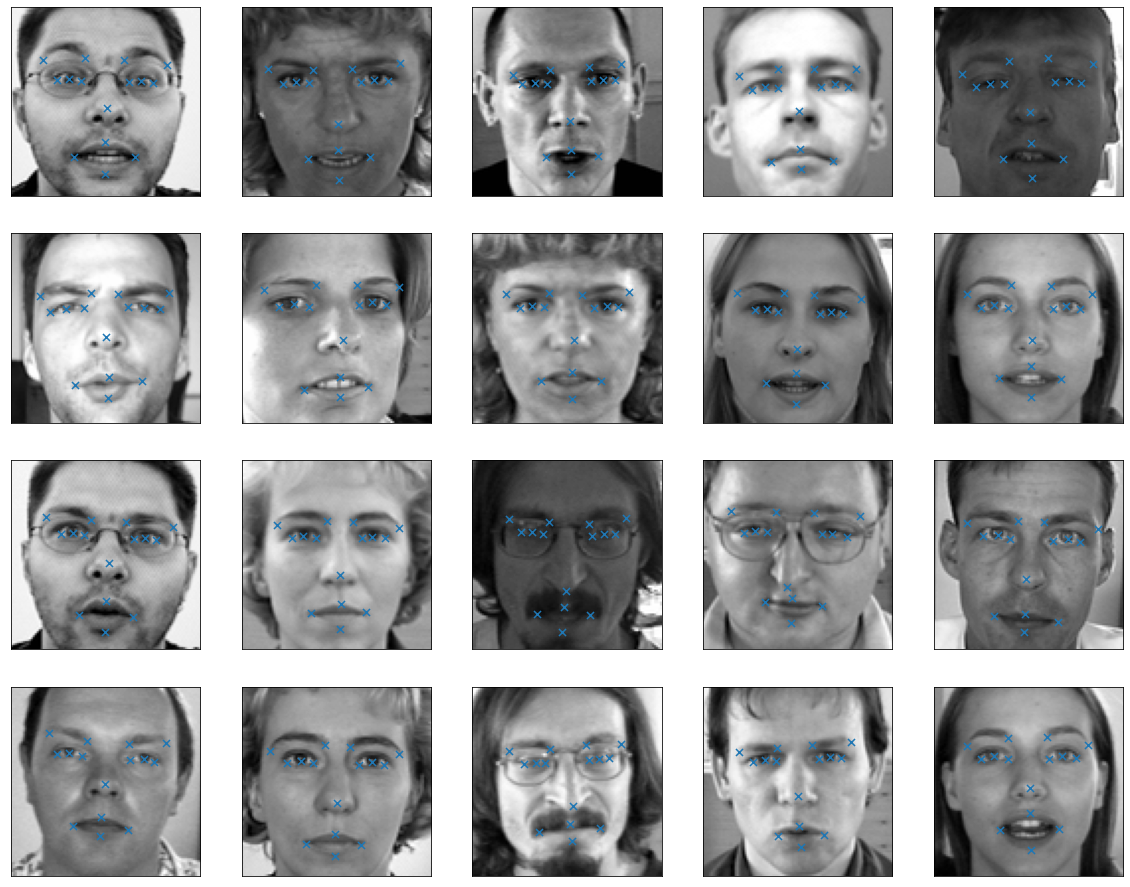

In [23]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")